# <font color='#A533FF'>Module 1: Business Understanding</font>

AirBnB is an online-platform dedicated to the offer of accommodation to individuals and tourists (vacation rentals) through which hosts can advertise and contract the rental of their properties with their guests. For this project we will explore and analyze the AirBnB data of Valencia (Spain), a city on the shores of the Mediterranean Sea.


#### Project Structure:

The project follow the CRISP-DM Process (Cross Industry Process for Data Mining):

1. Business Understanding.
2. Data Understanding.
3. Data Preparation.
4. Data Modelling.
5. Result Evaluation.
6. Deployment (available on GitHub repository and Medium Blog Post only).



#### Questions:



- A. What are the busiest times of the year to visit Valencia? By how much do prices spike?

- B. What type of airbnb is the most booked in the city? Where are they in the city?

- C. How well can we predict the Airbnb price? What aspects correlate well to the price?

# <font color='#A533FF'>Module 2: Data Understanding</font>

I choose the following datasets, available on http://insideairbnb.com/get-the-data/, to answer the above questions:

- calendar.csv: Contains information about [...].

- listings.csv: Contains information about [...].

** DESCRIBIR VARIABLES E INFO CONTENIDA EN ESOS DATASETS



### Importing libraries and loading the data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
calendar = pd.read_csv("calendar_2021.csv")
listings = pd.read_csv("listings.csv")

### Exploring 'calendar' dataset 

In [7]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,193326,2021-06-28,t,$45.00,$45.00,1.0,1125.0
1,48154,2021-06-28,f,$45.00,$45.00,3.0,25.0
2,48154,2021-06-29,f,$45.00,$45.00,3.0,25.0
3,48154,2021-06-30,f,$45.00,$45.00,3.0,25.0
4,48154,2021-07-01,f,$45.00,$45.00,3.0,25.0


In [8]:
# Finding NaN values for calendar df
print(calendar.shape)
print(calendar.isnull().sum())

(1981222, 7)
listing_id           0
date                 0
available            0
price             1114
adjusted_price    1114
minimum_nights      25
maximum_nights      25
dtype: int64


In [9]:
calendar.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

We see that 'price' and 'adjusted_price' are shown as type object. It is needed to transform them to numeric as well as remove the dollar symbol in order to achieve it.

In [10]:
# calendar["price"] = calendar[]

In [11]:
# Note: this function only takes numerical variables
calendar.describe()

,listing_id,minimum_nights,maximum_nights
count,1.981222e+06,1.981197e+06,1.981197e+06
mean,2.947478e+07,5.459868e+00,8.606587e+02
std,1.442925e+07,1.708297e+01,4.628115e+02
min,4.815400e+04,1.000000e+00,1.000000e+00
25%,1.808551e+07,2.000000e+00,3.650000e+02
50%,2.988804e+07,2.000000e+00,1.125000e+03
75%,4.266539e+07,4.000000e+00,1.125000e+03
max,5.064875e+07,3.650000e+02,1.000000e+04


In [12]:
calendar.columns[calendar.isnull().mean() > 0.05]

Index([], dtype='object')

It is shown that the % of NaN values is less than the 5% of the total data available, so I proceed to drop the NaN values of this dataset.

In [13]:
calendar = calendar.dropna()
print("The new dataframe has " + str(calendar.shape[0]) + " rows and " + str(calendar.shape[1]) + " columns.")

The new dataframe has 1980083 rows and 7 columns.


In [14]:
# Knowing the data period of time:
print("Dates are between " + min(calendar["date"]) + " and " + max(calendar["date"]) + ".")

Dates are between 2021-06-27 and 2022-06-28.


### Exploring 'listings' dataset 

In [15]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20211218004345,2021-12-18,beautiful apartment wifi,<b>The space</b><br />Hello everybody and than...,NaN,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,https://www.airbnb.com/users/show/219476,...,4.72,4.44,4.52,VT-41540-V,f,2,2,0,0,0.84
1,55692,https://www.airbnb.com/rooms/55692,20211218004345,2021-12-18,Delight in city center,A great place to stay and visit Valencia.<br /...,NaN,https://a0.muscache.com/pictures/329316/a5d6a7...,120649,https://www.airbnb.com/users/show/120649,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.01
2,95393,https://www.airbnb.com/rooms/95393,20211218004345,2021-12-18,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,"This is ""Edificio Palomar Apartments"", I will ...",It is just 10 min walking distance to the Cath...,https://a0.muscache.com/pictures/931683/64aebc...,508042,https://www.airbnb.com/users/show/508042,...,4.75,4.75,4.67,31815,f,6,6,0,0,0.80
3,100347,https://www.airbnb.com/rooms/100347,20211218004345,2021-12-18,3BDR full Home at Sorolla station and Metro Jesús,Te va a encantar mi espacio por la ubicación y...,"Barrio de Jesús, cercano al centro, zona conso...",https://a0.muscache.com/pictures/b0bb18e8-1f24...,1451371,https://www.airbnb.com/users/show/1451371,...,4.89,4.80,4.65,NaN,f,1,1,0,0,2.71
4,102524,https://www.airbnb.com/rooms/102524,20211218004345,2021-12-18,EXCLUSIVE VILLA WITH POOL & 5 SUITES ON THE BEACH,DO NOT PARTY OR STAG/HEN PARTIES! THE RESERVAT...,Best restaurantes bars and clubs and chill out...,https://a0.muscache.com/pictures/d2019707-1596...,535881,https://www.airbnb.com/users/show/535881,...,4.61,4.78,4.36,VT-36438-V,f,7,6,1,0,1.19


In [16]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [17]:
# Finding NaN values for listings df
print(listings.shape)
print(listings.isnull().sum())

(5546, 74)
id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
name                                              0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               727
Length: 74, dtype: int64


In [18]:
listings.columns[listings.isnull().mean() > 0.5]

Index(['host_neighbourhood', 'bathrooms', 'calendar_updated', 'license'], dtype='object')

The columns 'host_neighbourhood', 'bathrooms', 'calendar_updated' and 'license' have more than 50% of NaN values. We need to keep exploring this.

In [19]:
neighbourhood_counts = listings["neighbourhood_group_cleansed"].value_counts().reset_index()

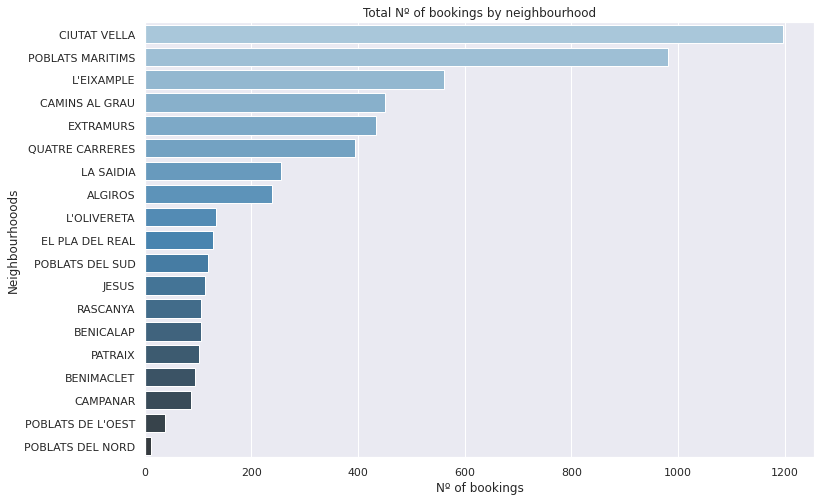

In [20]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(x= "neighbourhood_group_cleansed", y = "index", data = neighbourhood_counts, palette="Blues_d").set(title='Total Nº of bookings by neighbourhood')
plt.xlabel('Nº of bookings')
plt.ylabel('Neighbourhooods')
plt.show()

Ciutat Vella and Poblats Marítims are the most requested neighbourhoods by the users for this period of time.

# <font color='#A533FF'>Module 3: Data Preparation</font>

### 1. What are the busiest times of the year to rent a room in Valencia? By how much do prices spike?

To represent availability through time we need the 'available' column of the dataset that is True ('t') and then plot it with the dates.

In [21]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,193326,2021-06-28,t,$45.00,$45.00,1.0,1125.0
1,48154,2021-06-28,f,$45.00,$45.00,3.0,25.0
2,48154,2021-06-29,f,$45.00,$45.00,3.0,25.0
3,48154,2021-06-30,f,$45.00,$45.00,3.0,25.0
4,48154,2021-07-01,f,$45.00,$45.00,3.0,25.0


<AxesSubplot:title={'center':'Valencia Airbnb availability rate by month'}, xlabel='month'>

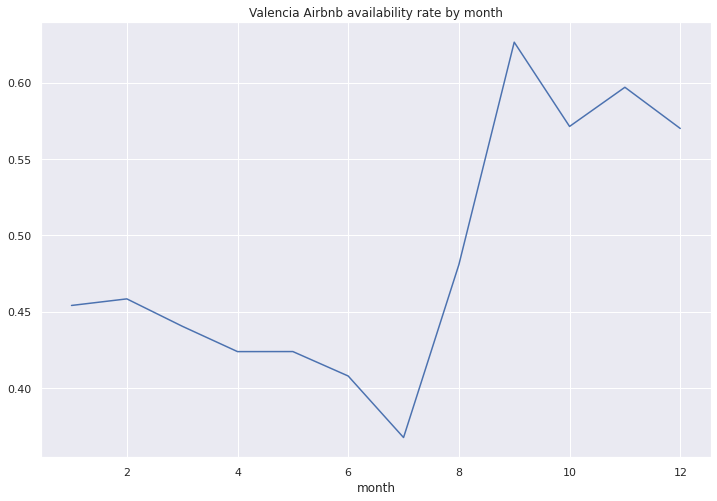

In [22]:
calendar['available'] = calendar['available'] == 't'
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar.groupby('month')['available'].mean().plot(title = 'Valencia Airbnb availability rate by month')

Taking into account that the time period of our data is from 2021-12-18 to 2022-12-17, we observe that [...]

Text(0, 0.5, 'price')

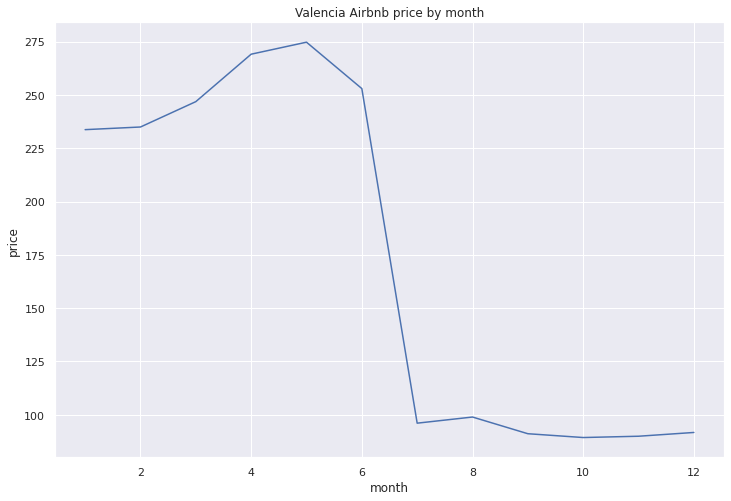

In [23]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['month'] = pd.DatetimeIndex(calendar['date']).month

ax2 = calendar.groupby('month')['price'].mean().plot(title='Valencia Airbnb price by month')
ax2.set_ylabel("price")

Summer months (July and August) are the most expensive of the year, over $138/ night. A peak is observed in March, month when Fallas are celebrated and also there is a peak in November.

### 2.  What type of airbnb is the most booked in the city? Where are they in the city?

# <font color='#A533FF'>Module 4: Data Modelling</font>

### Question 3. How well can we predict the Airbnb price? What aspects correlate well to the price?

Multiple Linear Regression:
'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location','review_scores_value', 'accommodates', 'bedrooms', 'beds', 'price','minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_365', 'number_of_reviews'
    
    
'instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified' -> boolean -> convertir a dos columnas

'host_response_rate', 'host_acceptance_rate' -> en porcentajes + nan -> convertir a int y mirar % NaN

'bathrooms_text' -> quedarse solo con los numeros

'property_type', 'room_type' -> texto pero estaria guay sacar datos

In [25]:
listings.property_type

0                Entire rental unit
1                Entire rental unit
2                Entire rental unit
3                Entire rental unit
4                      Entire villa
                   ...             
5541                   Entire cabin
5542                    Entire loft
5543     Entire condominium (condo)
5544                   Entire cabin
5545    Private room in rental unit
Name: property_type, Length: 5546, dtype: object

# <font color='#A533FF'>Module 5: Result Evaluation</font>

# <font color='#A533FF'>Module 6: Deployment </font>

This section is available on the following sites:

[...]